In [1]:
###Python Packages###

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import LogNorm
import math as mth
import timeit
import Double_Null_utils as dnu
from scipy import optimize

#!jupyter-theme -t onedork

In [2]:
###Initial Values###

M0=1.0
Q=0.95
Lambda=0.0005
scalarfield=True

In [3]:
Tol=1.0
N=5
Nul=5
Nup=10**(80)#*Tol

scal=1
umax=13
vmax=150


ru0=5.0
dr0v=.4

bdytype="stan"
scaltostan=False
solveaffine=False

Elist=[1]
#Elist=[1,2,4,8,16]

#uloc=[1/8,1/4,3/8,1/2,5/8]
#uloc=[1/5,2/5,3/5,4/5,9/10]
uloc=[8.2/10]

In [4]:
###Defining Needed Constants###

scalf=float(scal)
u0=0.0
v0=0.0
rv0=ru0
phiu0=0.0
phiv0=0.0

if M0==0.0:
    du00=1/N
    du0=du00
else:
    du00=M0/N
    du0=du00
dv00=du00
dv0=du0


def fr(r,M0,Q,Lambda):
    return 1-2*M0/r+Q**2.0/r**2.0-Lambda*r**2.0/3.0

sol = optimize.root(fr,[0.687,1.3,50.0],args=(M0,Q,Lambda), method='hybr')
rminus=sol.x[0]
rplus=sol.x[1]
rcosm=sol.x[2]



print("r+: "+str(rplus))
print("r-: "+str(rminus))
print("rc: "+str(rcosm))

###Predicting Run time###

###timer
start = timeit.default_timer()

Nu=Nul*umax*100#int(umax/du0)
Nv=int(vmax/dv0)
#print("Number of points for lowest iteration is "+str(Nu*Nv)+","+str(Nu)+"X"+str(Nv))
print("Number of points for highest iteration is "+str(Nu*Nv*max(Elist)**2)+","+str(Nu*max(Elist))+"X"+str(Nv*max(Elist)))

numpoints=0.0
for i in range(0,len(Elist)):
    numpoints=Elist[i]**2.0*Nu*Nv+numpoints
print("Total number of points is "+str(int(numpoints)))

predtime=numpoints/(56000)

print("Runtime: about "+str(format(predtime/60,'.2f'))+" minutes")


r+: 1.31304218328
r-: 0.687690417604
rc: 76.445748956
Number of points for highest iteration is 4875000,6500X750
Total number of points is 4875000
Runtime: about 1.45 minutes


In [5]:
##################################
###Applying Boundary Conditions###

Emax=max([Elist])

rnpf=np.zeros((Nv))
signpf=np.zeros((Nv))
phinpf=np.zeros((Nv))
#dphinpuf=np.zeros((Nu),len(Elist))) 
massnpf=np.zeros((Nv))


#tempsignpu=np.zeros((Nu*max(Elist),Nv*max(Elist)))




rnpf, signpf, phinpf = dnu.boundaryv(scal,bdytype,Nv,ru0,dr0v,dv0,vmax,M0,Q,scalarfield)



print(rnpf)

[  5.     5.08   5.16   5.24   5.32   5.4    5.48   5.56   5.64   5.72
   5.8    5.88   5.96   6.04   6.12   6.2    6.28   6.36   6.44   6.52
   6.6    6.68   6.76   6.84   6.92   7.     7.08   7.16   7.24   7.32
   7.4    7.48   7.56   7.64   7.72   7.8    7.88   7.96   8.04   8.12
   8.2    8.28   8.36   8.44   8.52   8.6    8.68   8.76   8.84   8.92   9.
   9.08   9.16   9.24   9.32   9.4    9.48   9.56   9.64   9.72   9.8
   9.88   9.96  10.04  10.12  10.2   10.28  10.36  10.44  10.52  10.6
  10.68  10.76  10.84  10.92  11.    11.08  11.16  11.24  11.32  11.4
  11.48  11.56  11.64  11.72  11.8   11.88  11.96  12.04  12.12  12.2
  12.28  12.36  12.44  12.52  12.6   12.68  12.76  12.84  12.92  13.    13.08
  13.16  13.24  13.32  13.4   13.48  13.56  13.64  13.72  13.8   13.88
  13.96  14.04  14.12  14.2   14.28  14.36  14.44  14.52  14.6   14.68
  14.76  14.84  14.92  15.    15.08  15.16  15.24  15.32  15.4   15.48
  15.56  15.64  15.72  15.8   15.88  15.96  16.04  16.12  16.2   16.2

In [6]:
drunp=np.empty((Nv))*np.nan
dsigunp=np.empty((Nv))*np.nan
urange=[0.0]



###Applying Propagation Algorithm###


dphinpuf=np.array([0.0])


drunp[0]=-mth.exp(signpf[0])/(4.0*dr0v)*(1-2*M0/ru0+Q**2.0/ru0**2.0+Lambda*ru0**2/3)
if bdytype=="edd":
    #dsigunp[0]=2.0*(M0*rnpf[0]-Q**2.0)/(rnpf[0]*(Q**2.0+rnpf[0]*(-2*M0+rnpf[0])))*drunp[0]
    dsigunp[0]=2*(3*Q**2-3*M0*r+r**4*Lambda)/(r*(-3*Q**2+r*(6*M0-3*r+r**3*Lambda)))
else:
    dsigunp[0]=0.0

i=0
dv=dv0
du0=M0/Nul
if bdytype=="edd":
    bdyvalue=1.0
else:
    bdyvalue=0.0
    
while max(urange)<umax:
    
    rnpf=np.insert(rnpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    phinpf=np.insert(phinpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    signpf=np.insert(signpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    massnpf=np.insert(massnpf,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    drunp=np.insert(drunp,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    dsigunp=np.insert(dsigunp,(i+1)*Nv,np.empty((Nv))*np.nan).reshape(i+2,Nv)
    dphinpuf=np.insert(dphinpuf,(i+1),np.empty((1))*np.nan).reshape(i+2)
    #print(rnpf)
    
    du=abs(du0*Tol/mth.exp(np.nanmax(signpf[i,:])))
    
    #print(du)
    
    if du<1/Nup*1.1:
        du=1/Nup
     
    #print(du)
    
    if du>=1/Nul:
        #print('r='+str(rnpf[i][0]))
        if rnpf[i][0]<rplus:
            du=1/(10*Nul)
            print(rplus)
        else:
            du=1/Nul
    
    print("%.80f" % du)
    print("%.64f" % urange[i])
    
    
    rnpf[i+1][0]=rnpf[i][0]+du*drunp[i][0]
    drunp[i+1][0]=drunp[i][0]+du*drunp[i][0]*dsigunp[i][0]
    
    phinpf[i+1][0]=0.0
    
    signpf[i+1][0]=signpf[i][0]+du*dsigunp[i][0]
    dsigunp[i+1][0]=2.0*(M0*rnpf[i+1][0]-Q**2.0)/(rnpf[i+1][0]*(Q**2.0+rnpf[i+1][0]*(-2*M0+rnpf[i+1][0])))*drunp[i+1][0]*bdyvalue
    
    
    
    
    #print(rnpf[1][0])
    for j in range(0,Nv-1):
        answer=dnu.x4giveralt(i,j,du,dv,rnpf,phinpf,signpf,Q,Lambda)
        rnpf[i+1][j+1]=answer[0]
        phinpf[i+1][j+1]=answer[1]
        signpf[i+1][j+1]=answer[2]
        massnpf[i+1][j+1]=answer[3]
        drunp[i+1][j+1]=answer[4]
        dsigunp[i+1][j+1]=answer[5]
        #dsignp[i+1][j+1]=answer[6]
            
        #print(rnpf[i+1][j+1])
        
        #du1=abs(du0*Tol/mth.exp(signpf[i][j+1])) #/(rnpf[i+1][j+1]-rnpf[i][j+1]))
        #print(du1)
        #du1=abs((rnpf[i+1][j+1]-rnpf[i][j+1])/(mth.exp(signpf[i][j+1])*Tol*du))
        #du1=abs((rnpf[i+1][j+1]-rnpf[i][j+1])/(Tol))
        #print(du1)
        #print(du1)
        #duminlist.append(du1)
    

    urange.append(urange[i]+du) 
    
    
    #du=np.nanmin(duminlist) 
    
    #print(urange[i]+du)
    if rnpf[i][0]<0.0:
        break
   
    dumaxlist=[]
    i+=1
    
    if i>10000:
        break
    
    


0.20000000000000001110223024625156540423631668090820312500000000000000000000000000
0.0000000000000000000000000000000000000000000000000000000000000000
0.19790026636680208005358849732147064059972763061523437500000000000000000000000000
0.2000000000000000111022302462515654042363166809082031250000000000
0.19578176005930136849286782307899557054042816162109375000000000000000000000000000
0.3979002663668020911558187435730360448360443115234375000000000000
0.19364432755219890269771099156059790402650833129882812500000000000000000000000000
0.5936820264261034596486865666520316153764724731445312500000000000
0.19148783944738848039612832963030086830258369445800781250000000000000000000000000
0.7873263539783024178575487894704565405845642089843750000000000000
0.18931219269310461950084345517097972333431243896484375000000000000000000000000000
0.9788141934256908704981015034718438982963562011718750000000000000
0.18711731290473176958499834654503501951694488525390625000000000000000000000000000
1.168126386118795

0.06237158030124208968336674274723918642848730087280273437500000000000000000000000
7.6889568962115735217821566038765013217926025390625000000000000000
0.06040857949775346041887402748216118197888135910034179687500000000000000000000000
7.7513284765128158682045977911911904811859130859375000000000000000
0.05848867263636422370032263984285236801952123641967773437500000000000000000000000
7.8117370560105694465846681850962340831756591796875000000000000000
0.05661250172895767457381666076798865105956792831420898437500000000000000000000000
7.8702257286469334829348554194439202547073364257812500000000000000
0.05478058963222368071832590885605895891785621643066406250000000000000000000000000
7.9268382303758908591362342122010886669158935546875000000000000000
0.05299334098129297732082676475329208187758922576904296875000000000000000000000000
7.9816188200081148451658918929751962423324584960937500000000000000
0.05125104398637297942187274202296976000070571899414062500000000000000000000000000
8.034612160989407

0.00903118716210762895180153009278001263737678527832031250000000000000000000000000
9.2676946417817607226652398821897804737091064453125000000000000000
0.00873766556653659577647008660505889565683901309967041015625000000000000000000000
9.2767258289438689899952805717475712299346923828125000000000000000
0.00845452416231875884811142185526477987878024578094482421875000000000000000000000
9.2854634945104059795539797050878405570983886718750000000000000000
0.00818136382055562917658964039446800597943365573883056640625000000000000000000000
9.2939180186727252674927512998692691326141357421875000000000000000
0.00791780143677630991738691790260418201796710491180419921875000000000000000000000
9.3020993824932816096406895667314529418945312500000000000000000000
0.00766346934840131562005627330336210434325039386749267578125000000000000000000000
9.3100171839300571718922583386301994323730468750000000000000000000
0.00741801476061132534361997059590976277831941843032836914062500000000000000000000
9.317680653278458

0.00160458564167928366232807046998232181067578494548797607421875000000000000000000
9.5078862193369992894531605998054146766662597656250000000000000000
0.00155857006881838676057294712506973155541345477104187011718750000000000000000000
9.5094908049786788239998713834211230278015136718750000000000000000
0.00151394772360941530509048646990777342580258846282958984375000000000000000000000
9.5110493750474969232300281873904168605804443359375000000000000000
0.00147067386485234081680562034932790993480011820793151855468750000000000000000000
9.5125633227711059447528896271251142024993896484375000000000000000
0.00142870529433772493199672481978268478997051715850830078125000000000000000000000
9.5140339966359590562205994501709938049316406250000000000000000000
0.00138800029852071305121186117759179978747852146625518798828125000000000000000000
9.5154627019302964185953896958380937576293945312500000000000000000
0.00134851859265688054159704201140357326949015259742736816406250000000000000000000
9.516850702228817

0.00033656020050806372814408695681720473658060654997825622558593750000000000000000
9.5535085787065252560523731517605483531951904296875000000000000000
0.00032768156697439231690369143557006736955372616648674011230468750000000000000000
9.5538451389070324637486919527873396873474121093750000000000000000
0.00031904929655531715556454619431292485387530177831649780273437500000000000000000
9.5541728204740064001043720054440200328826904296875000000000000000
0.00031065621887322469483680431601158034027321264147758483886718750000000000000000
9.5544918697705618626514478819444775581359863281250000000000000000
0.00030249538196765738328961048431153812998672947287559509277343750000000000000000
9.5548025259894355798451215378008782863616943359375000000000000000
0.00029456004533250215509862512952565793966641649603843688964843750000000000000000
9.5551050213714034953227383084595203399658203125000000000000000000
0.00028684367318660883815206741331849116249941289424896240234375000000000000000000
9.555399581416736

0.00007214463825060894557050783504337232443504035472869873046875000000000000000000
9.5638380773207032348182110581547021865844726562500000000000000000
0.00007038980522901179840908336693416913476539775729179382324218750000000000000000
9.5639102219589542386302127852104604244232177734375000000000000000
0.00006867987316340347619513656551859526189218740910291671752929687500000000000000
9.5639806117641832372555654728785157203674316406250000000000000000
0.00006701363607726920168603662597561765323916915804147720336914062500000000000000
9.5640492916373460730028455145657062530517578125000000000000000000
0.00006538992191159799939170066407356785020965617150068283081054687500000000000000
9.5641163052734228244844416622072458267211914062500000000000000000
0.00006380759152873291832532703926617045908642467111349105834960937500000000000000
9.5641816951953337877512240083888173103332519531250000000000000000
0.00006226553774670327357290688929936095519224181771278381347656250000000000000000
9.564245502786862

0.00001904718842725137734235574260566181692411191761493682861328125000000000000000
9.5660805593382622902254297514446079730987548828125000000000000000
0.00001861496803973718152888129628852453834042535163462162017822265625000000000000
9.5660996065266896692946829716674983501434326171875000000000000000
0.00001819305480331930938175423462244140182519913651049137115478515625000000000000
9.5661182214947295676665817154571413993835449218750000000000000000
0.00001778119080091725259839055550692421547864796593785285949707031250000000000000
9.5661364145495326738455332815647125244140625000000000000000000000
0.00001737912487595928164420613915019941941864090040326118469238281250000000000000
9.5661541957403333213960650027729570865631103515625000000000000000
0.00001698661244712342801785331936059719737386330962181091308593750000000000000000
9.5661715748652085267167421989142894744873046875000000000000000000
0.00001660341532836323382338501730703939074373920448124408721923828125000000000000
9.566188561477655

0.00000560257561667325397779032200573645638996822526678442955017089843750000000000
9.5666878089051614608706586295738816261291503906250000000000000000
0.00000548310109260548223978444168369428268761112121865153312683105468750000000000
9.5666934114807773426036874298006296157836914062500000000000000000
0.00000536630019611837544784389494867404835076740710064768791198730468750000000000
9.5666988945818705047940966323949396610260009765625000000000000000
0.00000525211020948055159741863981426313046085851965472102165222167968750000000000
9.5667042608820658244894730160012841224670410156250000000000000000
0.00000514046995516253939635361105975341899920749710872769355773925781250000000000
9.5667095129922756768792169168591499328613281250000000000000000000
0.00000503131975629717271387367910628896083835570607334375381469726562500000000000
9.5667146534622311548901052447035908699035644531250000000000000000
0.00000492460139820048891425583251213460300732549512758851051330566406250000000000
9.566719684781986

0.00000147455606506320666700246471009227988702150469180196523666381835937500000000
9.5668863841054001539987439173273742198944091796875000000000000000
0.00000144510117930720135839492163781772049446772143710404634475708007812500000000
9.5668878586614649606190141639672219753265380859375000000000000000
0.00000141626256073459422006805604604684489800092705991119146347045898437500000000
9.5668893037626450137622668989934027194976806640625000000000000000
0.00000138802671402291987800615199327713966681585588958114385604858398437500000000
9.5668907200252064626511128153651952743530273437500000000000000000
0.00000136038045287037247151875826722822182546224212273955345153808593750000000000
9.5668921080519204735992389032617211341857910156250000000000000000
0.00000133331089260505058867586555826356686793587869033217430114746093750000000000
9.5668934684323740924583034939132630825042724609375000000000000000
0.00000130680544297839989227713510672179708649309759493917226791381835937500000000
9.566894801743266

0.00000043723371747534910830985640031731698229577887104824185371398925781250000000
9.5669395084101580550850485451519489288330078125000000000000000000
0.00000042898383990926797512154076789936407720915667596273124217987060546875000000
9.5669399456438757312071174965240061283111572265625000000000000000
0.00000042089668669702543661104762046099025951662042643874883651733398437500000000
9.5669403746277161815214640228077769279479980468750000000000000000
0.00000041296890390584568978672459077516876391200639773160219192504882812500000000
9.5669407955244025743013480678200721740722656250000000000000000000
0.00000040519720979094294399625812014287262741163431201130151748657226562500000000
9.5669412084933060924640813027508556842803955078125000000000000000
0.00000039757839317437415762747214033334675065134433680213987827301025390625000000
9.5669416136905152114877637359313666820526123046875000000000000000
0.00000039010931186187061458164144697735586930775752989575266838073730468750000000
9.566942011268908

0.00000015423336259648681358435187444683167612424767867196351289749145507812500000
9.5669547982943594632843087310902774333953857421875000000000000000
0.00000015145621701747126829328818006792367611978988861665129661560058593750000000
9.5669549525277215451524170930497348308563232421875000000000000000
0.00000014873125115891499530227097720935791613783294451422989368438720703125000000
9.5669551039839380024432102800346910953521728515625000000000000000
0.00000014605744211980228614028041664307799862854153616353869438171386718750000000
9.5669552527151893173140706494450569152832031250000000000000000000
0.00000014343378791190887561871384302258913834293707623146474361419677734375000000
9.5669553987726310140260466141626238822937011718750000000000000000
0.00000014085930701413272436711828991540151889694243436679244041442871093750000000
9.5669555422064185279396042460575699806213378906250000000000000000
0.00000013833303793685923011813024719601772360988434229511767625808715820312500000
9.566955683065724

0.00000005133029144392593151523411835156218696596397421672008931636810302734375000
9.5669606241193481110940410871990025043487548828125000000000000000
0.00000005044856916390147307266981135595584895270349079510197043418884277343750000
9.5669606754496392397868476109579205513000488281250000000000000000
0.00000004958261846715639062032512213683277391140791223733685910701751708984375000
9.5669607258982090058907488128170371055603027343750000000000000000
0.00000004873214553334657633710272567686971889600044960388913750648498535156250000
9.5669607754808279054259401164017617702484130859375000000000000000
0.00000004789686224223819897508346065187478934888076764764264225959777832031250000
9.5669608242129733355341159040108323097229003906250000000000000000
0.00000004707648605861337652986933202323149849632955010747537016868591308593750000
9.5669608721098349235489877173677086830139160156250000000000000000
0.00000004627073991957836522158473060301053791931735759135335683822631835937500000
9.566960919186321

0.00000001854240275506100866689102295986613100353679328691214323043823242187500000
9.5669625658980237403739010915160179138183593750000000000000000000
0.00000001823680351105018504756124489343122041518086007272358983755111694335937500
9.5669625844404269088272485532797873020172119140625000000000000000
0.00000001793643823402983981687129361876076316661965392995625734329223632812500000
9.5669626026772309757006951258517801761627197265625000000000000000
0.00000001764121372585028673861532778639055196734375385858584195375442504882812500
9.5669626206136690882431139471009373664855957031250000000000000000
0.00000001735103851390472248479926453690325161005603149533271789550781250000000000
9.5669626382548820231477293418720364570617675781250000000000000000
0.00000001706582281791102304660557589192221294993601077294442802667617797851562500
9.5669626556059199629089562222361564636230468750000000000000000000
0.00000001678547851736601151358409494789014626547896114061586558818817138671875000
9.566962672671742

0.00000000664350766142750928285257562382060125827365482109598815441131591796875000
9.5669632997575426713865454075857996940612792968750000000000000000
0.00000000653824541572902879337382108654308510153896349947899580001831054687500000
9.5669633064010497491835849359631538391113281250000000000000000000
0.00000000643471248795140173448384716308259823058790516370208933949470520019531250
9.5669633129392952497482838225550949573516845703125000000000000000
0.00000000633287939695905986993674049350191990193081892357440665364265441894531250
9.5669633193740075682853785110637545585632324218750000000000000000
0.00000000623271718334392540707604928691340506752283090463606640696525573730468750
9.5669633257068866782901750411838293075561523437500000000000000000
0.00000000613419739983750923153466125432864419764200647477991878986358642578125000
9.5669633319396041315485490486025810241699218750000000000000000000
0.00000000603729210191144419419671145795452948945580828876700252294540405273437500
9.566963338073801

0.00000000271267299710329665359117606762261870612107372835453134030103683471679688
9.5669635512730941684367280686274170875549316406250000000000000000
0.00000000267106087940897393978059265158900292824739608477102592587471008300781250
9.5669635539857669215280111529864370822906494140625000000000000000
0.00000000263010925516438252123329024820784505234172456766827963292598724365234375
9.5669635566568285156563433702103793621063232421875000000000000000
0.00000000258980726492110753580777048900828096744675121954060159623622894287109375
9.5669635592869379792091422132216393947601318359375000000000000000
0.00000000255014423428951843231079189507938542735843157061026431620121002197265625
9.5669635618767454587896281736902892589569091796875000000000000000
0.00000000251110967066824158506989523047172457870246375932765658944845199584960938
9.5669635644268904428599853417836129665374755859375000000000000000
0.00000000247269326003623228290271688397782695600923830170358996838331222534179688
9.566963566937999

0.00000000117321278521909287145934867949972554845849970206472789868712425231933594
9.5669636528603838598883157828822731971740722656250000000000000000
0.00000000115572085186376786831471722111035205227125288729439489543437957763671875
9.5669636540335964980386052047833800315856933593750000000000000000
0.00000000113849821354807340135275241531148324169997465560300042852759361267089844
9.5669636551893173503913203603588044643402099609375000000000000000
0.00000000112154058345294339089041681946888606713486069565988145768642425537109375
9.5669636563278164231860500876791775226593017578125000000000000000
0.00000000110484374538070255293089934214931929767899987382406834512948989868164062
9.5669636574493566172350256238132715225219726562500000000000000000
0.00000000108840355255076897546883379485228166005938987836998421698808670043945312
9.5669636585542008333504782058298587799072265625000000000000000000
0.00000000107221592641611086315962604636120233947416124919982394203543663024902344
9.566963659642604

0.00000000046177600384601001590239914417629091963890530792014033067971467971801758
9.5669637011764745437858437071554362773895263671875000000000000000
0.00000000045509110797819884917789187613870391380110902446176623925566673278808594
9.5669637016382509386858146172016859054565429687500000000000000000
0.00000000044850589523770079168041767968472862543327650541868933942168951034545898
9.5669637020933429027991223847493529319763183593750000000000000000
0.00000000044201883191022126737987450463248165211105344951647566631436347961425781
9.5669637025418481357519340235739946365356445312500000000000000000
0.00000000043562840865783330640245937136678308632120604215742787346243858337402344
9.5669637029838661135272559477016329765319824218750000000000000000
0.00000000042933314011857130864611924956361979632823988595191622152924537658691406
9.5669637034194945357512551709078252315521240234375000000000000000
0.00000000042313156451254056077987042047380047277149728301992581691592931747436523
9.566963703848827

0.00000000019188878218041985682255940948094836973059074125558254308998584747314453
9.5669637200240966734554604045115411281585693359375000000000000000
0.00000000018918084237770953234076740615839757816973865089948958484455943107604980
9.5669637202159858446748330607078969478607177734375000000000000000
0.00000000018651216834027692202870904810443853857893081737984175560995936393737793
9.5669637204051660717141203349456191062927246093750000000000000000
0.00000000018388217385591691543628138299186621992808987613443605368956923484802246
9.5669637205916782107806284329853951930999755859375000000000000000
0.00000000018129028173640046354581666136301888389570358128821681020781397819519043
9.5669637207755595653679847600869834423065185546875000000000000000
0.00000000017873592367399234670651700178888032777280159280053339898586273193359375
9.5669637209568492153266561217606067657470703125000000000000000000
0.00000000017621854010051391881977329936261305459721526744942821096628904342651367
9.566963721135584

0.00000000007920324799262476339935333180725975099623070718735107220709323883056641
9.5669637280894246345042120083235204219818115234375000000000000000
0.00000000007811129453187777965857218745706551203678014161368992063216865062713623
9.5669637281686270569025509757921099662780761718750000000000000000
0.00000000007703476801798661972693227956802681892500839211379570770077407360076904
9.5669637282467387962014981894753873348236083984375000000000000000
0.00000000007597344457140425159411075298489224826015142610913244425319135189056396
9.5669637283237740632557688513770699501037597656250000000000000000
0.00000000007492710365595044669305642020767465986963440371937394957058131694793701
9.5669637283997470689200781635008752346038818359375000000000000000
0.00000000007389552802734548106634121705305669886021391334907093551009893417358398
9.5669637284746738004059807281009852886199951171875000000000000000
0.00000000007287850368258590639609064048881539171764742945924808736890554428100586
9.566963728548568

9.5669637311998734219287143787369132041931152343750000000000000000
0.00000000003616427724053769345735428743442792156453924334869043377693742513656616
9.5669637312365338743802567478269338607788085937500000000000000000
0.00000000003567484027037240393891062780905212153959027432392758782953023910522461
9.5669637312726987232736064470373094081878662109375000000000000000
0.00000000003519217359453113853545454555668016687758337113223205960821360349655151
9.5669637313083732976792816771194338798522949218750000000000000000
0.00000000003471618122485473842776575678173455775932243483339334488846361637115479
9.5669637313435647030246400390751659870147705078125000000000000000
0.00000000003424676857095226707568746337733897860261533807602063461672514677047729
9.5669637313782800447370391339063644409179687500000000000000000000
0.00000000003378384241927536343562638642655786714447119223336812865454703569412231
9.5669637314125264282438365626148879528045654296875000000000000000
0.0000000000333273109124948004449

0.00000000001586443872552699470074155530211493453709992174083254212746396660804749
9.5669637327477410337905894266441464424133300781250000000000000000
0.00000000001565338002572809433555873235667315560709633714964184036944061517715454
9.5669637327636056767232730635441839694976806640625000000000000000
0.00000000001544518283670679907316042339450207643986034966587794770020991563796997
9.5669637327792589331920680706389248371124267578125000000000000000
0.00000000001523980749414896947840785817442023266504724787751001713331788778305054
9.5669637327947043559106532484292984008789062500000000000000000000
0.00000000001503721489722462678898200657667252530536039500930201029404997825622559
9.5669637328099437212358679971657693386077880859375000000000000000
0.00000000001483736650037710935476360643680128568316911596980389731470495462417603
9.5669637328249805818813911173492670059204101562500000000000000000
0.00000000001464022430521860902763148563787590043794306637892077560536563396453857
9.566963732839818

0.00000000000763176846421385019740538849954391556126842566243340115761384367942810
9.5669637333701533776775249862112104892730712890625000000000000000
0.00000000000753155040326033276923597131438764778858796500315975208650343120098114
9.5669637333777846066595884622074663639068603515625000000000000000
0.00000000000743266966512044343670634459875603324702231233800375775899738073348999
9.5669637333853163596586455241777002811431884765625000000000000000
0.00000000000733510804883066622309154164234166421026950288819534762296825647354126
9.5669637333927486366746961721219122409820556640625000000000000000
0.00000000000723884760679162965502963042221331484756680074710288863570895045995712
9.5669637334000832140645798062905669212341308593750000000000000000
0.00000000000714387064115334768050415632153010377959623244947806597338058054447174
9.5669637334073218681851358269341289997100830078125000000000000000
0.00000000000705015970025437353727814893033436043079387189891349407844245433807373
9.566963733414466

0.00000000000342405333814053470249877769362961243537063493747041320602875202894211
9.5669637336922512815817754017189145088195800781250000000000000000
0.00000000000337961186392317539155162796801487124030011210962243239919189363718033
9.5669637336956760975681390846148133277893066406250000000000000000
0.00000000000333575450352007918437594711194982136700376562643555189424660056829453
9.5669637336990565046335177612490952014923095703125000000000000000
0.00000000000329247344915455797934830714405303952411335766115030310174915939569473
9.5669637337023925027779114316217601299285888671875000000000000000
0.00000000000324976099953905991451262072879601733007073893766403216432081535458565
9.5669637337056840920013200957328081130981445312500000000000000000
0.00000000000320760955838769506223092694543000559905324142739857506967382505536079
9.5669637337089330486605831538327038288116455078125000000000000000
0.00000000000316601163295359916043064238400948565274259371982168431713944301009178
9.566963733712141

0.00000000000156903190363948172130642954053810010205810554495542419317644089460373
9.5669637338357311762138124322518706321716308593750000000000000000
0.00000000000154883912573531003994219948830554393014689862351218607727787457406521
9.5669637338372996993030028534121811389923095703125000000000000000
0.00000000000152890850651420094355262054445216530172702018575137117295525968074799
9.5669637338388486824669598718173801898956298828125000000000000000
0.00000000000150923659523558365621604299617903189451029177803320635575801134109497
9.5669637338403781257056834874674677848815917968750000000000000000
0.00000000000148981998738569943164239097081049610074229838652115631703054532408714
9.5669637338418880290191737003624439239501953125000000000000000000
0.00000000000147065532404494490168291019193656470986746043205783962548593990504742
9.5669637338433783924074305105023086071014404296875000000000000000
0.00000000000145173929126515936364902488660767781092006400989191661210497841238976
9.566963733844849

0.00000000000073226482774940114620358931015061194804826455451163269572134595364332
9.5669637339009110377219258225522935390472412109375000000000000000
0.00000000000072288943218070151628935202734956969635848195165905849535192828625441
9.5669637339016428967397587257437407970428466796875000000000000000
0.00000000000071363461185606311364405824300375631794989689238306596053007524460554
9.5669637339023658739733946276828646659851074218750000000000000000
0.00000000000070449879986424563720621244121009913883788011723652289219899103045464
9.5669637339030799694228335283696651458740234375000000000000000000
0.00000000000069548044996065715990890658203122205109191628080722580307337921112776
9.5669637339037851830880754278041422367095947265625000000000000000
0.00000000000068657803628989349722768705620301057067356165219962349510751664638519
9.5669637339044815149691203259862959384918212890625000000000000000
0.00000000000067779005311166455318043167491275937351635771932478746748529374599457
9.566963733905168

0.00000000000035613632614400717944906786376946361658175910225310190071468241512775
9.5669637339303257306255545699968934059143066406250000000000000000
0.00000000000035158399638977838446030934614488326216304170390714034510892815887928
9.5669637339306810019934346200898289680480957031250000000000000000
0.00000000000034708984352096325970865014891593205970631019763317226534127257764339
9.5669637339310327206476358696818351745605468750000000000000000000
0.00000000000034265311898488576247516539008855283003499372918021492750995093956590
9.5669637339313791102313189185224473476409912109375000000000000000
0.00000000000033827308397632559673906925596990915541990851966858144805883057415485
9.5669637339317219471013231668621301651000976562500000000000000000
0.00000000000033394900930875849344846685800550560135587299659398752282868372276425
9.5669637339320594549008092144504189491271972656250000000000000000
0.00000000000032968017528689663453710618536113755971516531273479699848394375294447
9.566963733932393

0.00000000000017096887156579329096516995975622411768905968554310703666487825103104
9.5669637339447977097961484105326235294342041015625000000000000000
0.00000000000016877869955659410441237249513460539273798644011037595191737636923790
9.5669637339449682400527308345772325992584228515625000000000000000
0.00000000000016661641824291039390893372297695293436105810902514434701515710912645
9.5669637339451369939524738583713769912719726562500000000000000000
0.00000000000016448167153115052882021922167780561682345896734602774813538417220116
9.5669637339453039714953774819150567054748535156250000000000000000
0.00000000000016237410791408715187939546590659439676083281023366566842014435678720
9.5669637339454691726814417052082717418670654296875000000000000000
0.00000000000016029338041103244200326706437823858996901717210992188711315975524485
9.5669637339456308211538271280005574226379394531250000000000000000
0.00000000000015823914650879751746967816689451029297532567985395957066430128179491
9.566963733945790

0.00000000000008287938779121638007192006609652505963014689632784026684930722694844
9.5669637339516544471962333773262798786163330078125000000000000000
0.00000000000008181057787266845042003013214052913794501441235862415624069399200380
9.5669637339517379359676851890981197357177734375000000000000000000
0.00000000000008075537632147002083579644062407209671261652111917683782849053386599
9.5669637339518196483822976006194949150085449218750000000000000000
0.00000000000007971361028114007001171612626175732037423111997487268354234402067959
9.5669637339518995844400706118904054164886474609375000000000000000
0.00000000000007868510910245710974525900142207762510233523545188916159531800076365
9.5669637339519795204978436231613159179687500000000000000000000000
0.00000000000007766970431498624137421209260190651336780084945665691975591471418738
9.5669637339520576801987772341817617416381835937500000000000000000
0.00000000000007666722959894703798840310460949395501026402272026771811397338751704
9.566963733952135

9.5669637339551272248172608669847249984741210937500000000000000000
0.00000000000003736537158573961910820278612439779787390619833487015455375512829050
9.5669637339551645283108882722444832324981689453125000000000000000
0.00000000000003687689292102532417022196734701077427449758885935615637663431698456
9.5669637339552018318045156775042414665222167968750000000000000000
0.00000000000003639466121115668643560175813075202673523228860674727513924153754488
9.5669637339552391352981430827639997005462646484375000000000000000
0.00000000000003591859731280810030200491777643140385627368652010638072624715277925
9.5669637339552746624349310877732932567596435546875000000000000000
0.00000000000003544862308673699674739380036932528811446712832533556536418473115191
9.5669637339553101895717190927825868129730224609375000000000000000
0.00000000000003498466138494788364439579853527798957259827700161380903409735765308
9.5669637339553457167085070977918803691864013671875000000000000000
0.0000000000000345266360380778035

9.5669637339566335754170722793787717819213867187500000000000000000
0.00000000000001776178787471438090578155907409220935113248855674594750553296762519
9.5669637339566513389854662818834185600280761718750000000000000000
0.00000000000001752495409563813421103205492340541312427286760322608927253895672038
9.5669637339566691025538602843880653381347656250000000000000000000
0.00000000000001729117982212659259422444700745302083202785403681644993412191979587
9.5669637339566868661222542868927121162414550781250000000000000000
0.00000000000001706042630589218284196577188397023306528862453268491350399926886894
9.5669637339567046296906482893973588943481445312500000000000000000
0.00000000000001683265528972860909593299940541548112901823128217948521978541975841
9.5669637339567223932590422919020056724548339843750000000000000000
0.00000000000001660782900134389486098432232159757922018228706861897592261811951175
9.5669637339567383804705968941561877727508544921875000000000000000
0.0000000000000163859101472385131

0.00000000000000841084276653298976019993233012310819062885055424905189624951162841
9.5669637339573458945096717798151075839996337890625000000000000000
0.00000000000000829576748504774734609973904948500999507576391528429482491446833592
9.5669637339573547762938687810674309730529785156250000000000000000
0.00000000000000818221182490269218685591348153183308105479681210381315281665592920
9.5669637339573636580780657823197543621063232421875000000000000000
0.00000000000000807015667482749818610861354255068749175537363288457370913420163561
9.5669637339573725398622627835720777511596679687500000000000000000
0.00000000000000795958317219577310691647081142866515999741757608765269083050952759
9.5669637339573814216464597848244011402130126953125000000000000000
0.00000000000000785047270014560582717316649824727300295004132207887792560541129205
9.5669637339573885270738173858262598514556884765625000000000000000
0.00000000000000774280688474761879873641674379876031105156709150039162636858236510
9.566963733957395

0.00000000000000391315105230508617860963884007323419901385169045182621516687504482
9.5669637339576691914544426253996789455413818359375000000000000000
0.00000000000000385898804567932162691492123713448886356913811873647901506956259254
9.5669637339576727441681214259006083011627197265625000000000000000
0.00000000000000380560464720159808155031592849495503627193756027158322297054837691
9.5669637339576762968818002264015376567840576171875000000000000000
0.00000000000000375299257047374785435292879715386217930462968428440007073731976561
9.5669637339576798495954790269024670124053955078125000000000000000
0.00000000000000370114371254643447147994970405041952909612002278749720574069215218
9.5669637339576834023091578274033963680267333984375000000000000000
0.00000000000000365005015612499630216294931781650256797961285465392577975762833375
9.5669637339576869550228366279043257236480712890625000000000000000
0.00000000000000359970417206706853705898724403239177547722408082031542164713755483
9.566963733957690

0.00000000000000194924222194598623178434471475878611259935401303633462077868898632
9.5669637339578201817857916466891765594482421875000000000000000000
0.00000000000000193527254612168795176340089984204394800402257263705063650149895693
9.5669637339578219581426310469396412372589111328125000000000000000
0.00000000000000192244302712735747413933527048968189017728392178896434927537484327
9.5669637339578237344994704471901059150695800781250000000000000000
0.00000000000000191082638025736684767060367464664657670772324876695691386885300744
9.5669637339578255108563098474405705928802490234375000000000000000
0.00000000000000190050577785419002979157808347561354541538098522623911890150338877
9.5669637339578272872131492476910352706909179687500000000000000000
0.00000000000000189157663667728875474519207307479380749643091581824183577964504366
9.5669637339578290635699886479414999485015869140625000000000000000
0.00000000000000188414878433803593089435617147935519733207773707128751539130462334
9.566963733957830

0.00000000000036404828124669952324020695164506906374348588206757426632975693792105
9.5669637339595645642020826926454901695251464843750000000000000000
0.00000000000044778288091655774318881283456683685948764017670242765234434045851231
9.5669637339599287173541597439907491207122802734375000000000000000
0.00000000000055173951208038895684332084909652120442886957807360204242286272346973
9.5669637339603763592776886071078479290008544921875000000000000000
0.00000000000068140964056937373560093623647852962286249750567534988476836588233709
9.5669637339609288062547420850023627281188964843750000000000000000
0.00000000000084406908080383989315846748677474514017862045056617148475197609513998
9.5669637339616109272810717811807990074157714843750000000000000000
0.00000000000104843037652224398320433490419619998001814209498405716658453457057476
9.5669637339624546967797869001515209674835205078125000000000000000
0.00000000000130564585225362108815591857809159211578284298660435069905361160635948
9.566963733963502

0.00002373611951218386554576453284504111707065021619200706481933593750000000000000
9.5670098551888589355485237319953739643096923828125000000000000000
0.00003637815972135311024665549339829340169671922922134399414062500000000000000000
9.5670335913083714984850303153507411479949951171875000000000000000
0.00005594180883385470244876722101246002694097114726901054382324218750000000000000
9.5670699694680934044299647212028503417968750000000000000000000000
0.00008631087135808015076317289970830870515783317387104034423828125000000000000000
9.5671259112769266863551820279099047183990478515625000000000000000
0.00013357904092343376631878137938969075548811815679073333740234375000000000000000
9.5672122221482851500695687718689441680908203125000000000000000000
0.00020732508723908830636228906030282814754173159599304199218750000000000000000000
9.5673458011892087426986108766868710517883300781250000000000000000
0.00032258397094931008652896053945369203574955463409423828125000000000000000000000
9.567553126276447

1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.8368504703465600158551751519553363323211669921875000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.8568504703465595895295336958952248096466064453125000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.8768504703465591632038922398351132869720458984375000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.8968504703465587368782507837750017642974853515625000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.9168504703465583105526093277148902416229248046875000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
10.9368504703465578842269678716547787189483642578125000000000000000
1.31304218

11.8968504703465374205961779807694256305694580078125000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
11.9168504703465369942705365247093141078948974609375000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
11.9368504703465365679448950686492025852203369140625000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
11.9568504703465361416192536125890910625457763671875000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
11.9768504703465357152936121565289795398712158203125000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
11.9968504703465352889679707004688680171966552734375000000000000000
1.31304218328
0.02000000000000000041633363423443370265886187553405761718750000000000000000000000
12.0168504

In [7]:
Nu=i+2

print(Nu)
#rnpf[i+1][j+1]=answer[0]
#phinpf[i+1][j+1]=answer[1]
#signpf[i+1][j+1]=answer[2]
#massnpf[i+1][j+1]=answer[3]
#drunp[i+1][j+1]=answer[4]
#dsigunp[i+1][j+1]=answer[5]

2119


In [8]:
print(rnpf[1,0])

4.91996666667


In [9]:
print(dnu.x4giveralt(0,0,du,dv,rnpf,phinpf,signpf,Q,Lambda))

[5.0010568678666436, 0.0, -0.0004379216010785401, -13.418167590348228, -3.9744116366672522, -0.010948040026963502]


In [10]:
print(rnpf)

[[  5.00000000e+00   5.08000000e+00   5.16000000e+00 ...,   6.47600000e+01
    6.48400000e+01   6.49200000e+01]
 [  4.91996667e+00   4.99934438e+00   5.07873998e+00 ...,   6.47259464e+01
    6.48061589e+01   6.48863716e+01]
 [  4.84077358e+00   4.91951688e+00   4.99829625e+00 ...,   6.46918895e+01
    6.47723144e+01   6.48527397e+01]
 ..., 
 [  7.18033678e-03   4.12111360e-01   4.94145503e-01 ...,   6.84912916e-01
    6.84775074e-01   6.84634632e-01]
 [ -8.22996550e-04   4.04308844e-01   4.87659961e-01 ...,   6.80257202e-01
    6.80118416e-01   6.79977012e-01]
 [ -8.82632988e-03   3.95638401e-01   4.80494925e-01 ...,   6.75145868e-01
    6.75006030e-01   6.74863555e-01]]


In [11]:
vrange=np.arange(0,vmax,dv0)
print(urange)

[0.0, 0.2, 0.3979002663668021, 0.5936820264261035, 0.7873263539783024, 0.9788141934256909, 1.1681263861187956, 1.3552436990235273, 1.5401468558073872, 1.7228165704381346, 1.9032335833819607, 2.0813787004801134, 2.2572328345729433, 2.430777049928312, 2.6019926095170525, 2.770861025161582, 2.9373641105646717, 3.1014840372036625, 3.2632033930510316, 3.4225052440550723, 3.5793731982845522, 3.7337914726086314, 3.885744961748113, 4.035219309496474, 4.182200981869325, 4.32667734189927, 4.468636725750073, 4.6080685197800495, 4.74496323814029, 4.879312600449483, 5.011109609044457, 5.140348625265036, 5.267025444194354, 5.391137367242489, 5.512683271933118, 5.631663678231014, 5.7480808107337475, 5.861938656044708, 5.973243014647772, 6.082001546617157, 6.18822381052002, 6.291921294904611, 6.3931074418134655, 6.491797661819155, 6.58800934014924, 6.6817618335465525, 6.773076457599859, 6.861976464377067, 6.948487010296837, 7.0326351142829795, 7.114449606357323, 7.193961066938635, 7.271201757225393, 7

In [22]:
np.save('rnp.npy',rnpf)
np.save('sig.npy',signpf)
np.save('phi.npy',phinpf)
np.save('mass.npy',massnpf)
np.save('rnputil',np.array([N,Nu,Nv,ru0,dr0v,M0,Q,Lambda]))
np.save('urange',urange)
np.save('vrange',vrange)

In [13]:
M=massnpf[10][-10]
#rplus=M+(M**2.0-Q**2.0)**.5
#rminus=M-(M**2.0-Q**2.0)**.5
print(M)

22.6421920046


In [14]:
levels=np.arange(10.0, np.nanmax(rnpf), 10.0 )


if rplus==0.0 and scalarfield==False:
    levels=np.insert(levels,0,[ru0])
if Q==0.0 and scalarfield==False and M0>0.0:
    levels=np.insert(levels,0,[1.0,rplus,3.0,4.0,ru0])
if scalarfield==True and Q==0.0 and M0>0.0:
    levels=np.insert(levels,0,[0.1,rplus,ru0])
if scalarfield==True and Q>0.0:
    levels=np.insert(levels,0,[.1,.2,.3,.4,.5,rminus,rplus,ru0])
if scalarfield==False and Q>0.0 and Lambda==0.0:
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.001,rminus+0.002,rminus+0.003,rminus+0.004,rminus+0.005,rminus+0.006,rminus+0.007,rminus+0.008,rminus+0.009,rminus+0.01,rminus+0.011,rminus+0.012,rminus+0.013,rminus+0.014,rminus+0.015,rminus+0.016,rminus+0.017,rminus+0.018,rminus+0.020,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus,rminus+0.003,rminus+0.006,rminus+0.009,rminus+0.012,rminus+0.015,rminus+0.018,rminus+0.025,rminus+0.030,rminus+0.035,rplus-0.5,rplus-0.4,rplus,ru0])
    #levels=np.insert(levels,0,[0.1,rminus-.01,rminus,.689,.690,.691,0.7,0.8,0.9,1.0,rplus,ru0])
    #levels=np.insert(levels,0,[.5,.6,.65,.67,.68,.685,.687,.8,.9,1.0,ru0])
    levels=np.insert(levels,0,[.683,.685,.69,1.0])#,10.0,15.0,20.0,25.0,30.0]
#if scalarfield==False and Lambda>0:
    #levels=np.insert(levels,0,[rminus,rplus])
    #levels=np.insert(levels,-1,[rcosm])
print(levels)  
print(np.nanmin(rnpf))
print(np.nanmax(rnpf))

[  0.1          0.2          0.3          0.4          0.5          0.68769042
   1.31304218   5.          10.          20.          30.          40.          50.
  60.        ]
-0.00882632988369
64.92


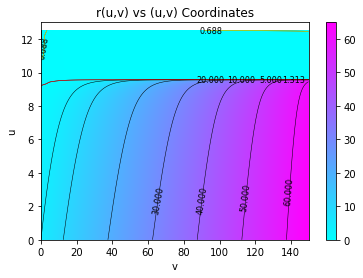

In [15]:
plot1=plt.pcolormesh(vrange,urange,np.ma.masked_invalid(rnpf),cmap=plt.cm.cool,vmin=0.0,vmax=np.nanmax(rnpf))#np.nanmax(rnpf[:,:,-1]))#np.nanmax(rnpf[:,:,-1]))# norm=LogNorm(vmin=0.6, vmax=.8))#

plt.xlim(0,vmax)
plt.ylim(0,umax)
#plt.xlim(0,5)
#plt.ylim(9.45378,9.45379)


plot4=plt.contour(vrange,urange,rnpf, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot5=plt.contour(vrange,urange,rnpf, [rminus],linewidths=0.6,colors='yellow',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rnpf, [rplus],linewidths=0.6,colors='red',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot6=plt.contour(vrange,urange,rnpf, [rcosm],linewidths=0.6,colors='green',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels, inline=0, inline_spacing=0, fmt='%1.3f',rightside_up=True, fontsize=8)
if solveaffine==True:
    CHorizon=plt.plot(CH.list,urange[-1][int(uEH*Nu*Elist[-1]):],color='g')
#sample3=plt.plot(vrange[-1],drdvnplistscal)

plt.xlabel('v')
plt.ylabel('u')


plt.colorbar(plot1)
plt.title('r(u,v) vs (u,v) Coordinates')
#plt.grid()
plt.savefig('r_0_lines.png',dpi=300)
plt.show()

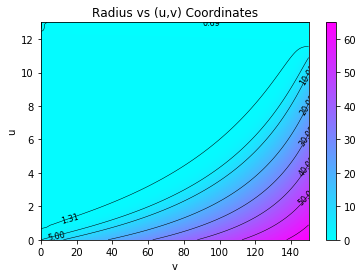

In [16]:
plot1=plt.imshow(rnpf,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
#plot1=plt.contourf(rnpf,levels,cmap=plt.cm.cool,extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plot4=plt.contour(rnpf, levels,linewidths=0.5,colors='black',extent=(0,vmax,0,umax),aspect='auto',origin='lower')
plt.clabel(plot4, levels,  inline=0, inline_spacing=0, fmt='%1.2f',rightside_up=True,fontsize=8)
#sample3=plt.plot(vrange[-1],drdvnplist)
#sample3=plt.plot(vrange,dsigdvnplist)
plt.xlabel('v')
plt.ylabel('u')
plt.xlim()
plt.colorbar(plot1)
plt.title('Radius vs (u,v) Coordinates')
#plt.savefig('Test1-2.png',dpi=300)
plt.show()

In [17]:
stop = timeit.default_timer()

In [18]:
acttime=stop - start

numpoints=Nu*Nv



print(str(acttime)+' seconds')
print(str((acttime)/60)+' minutes')
print(str((acttime)/3600)+' hours')

print(str(numpoints)+' points')

print(str((numpoints)/(stop - start))+' points per second') 

exttime=format((acttime-predtime)/60,'.2f')

print("Took "+str(exttime)+" more minutes")

59.46368653518512 seconds
0.9910614422530853 minutes
0.016517690704218088 hours
1589250 points
26726.395428908174 points per second
Took -0.46 more minutes


In [19]:
print(signpf[:,:])

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.30047111e-04   4.50912938e-04 ...,   1.05471831e-02
    1.05506758e-02   1.05541680e-02]
 [  0.00000000e+00   4.67355178e-04   9.16057870e-04 ...,   2.13028258e-02
    2.13098118e-02   2.13167968e-02]
 ..., 
 [  0.00000000e+00  -5.96651898e+00  -6.71729871e+00 ...,  -8.92868410e+01
   -8.95585664e+01  -8.98323568e+01]
 [  0.00000000e+00  -6.21752871e+00  -6.97427652e+00 ...,  -8.95504854e+01
   -8.98222080e+01  -9.00959956e+01]
 [  0.00000000e+00  -6.49394196e+00  -7.25760645e+00 ...,  -8.98413629e+01
   -9.01130824e+01  -9.03868669e+01]]


In [20]:
print(dsigunp)

[[  0.00000000e+00              nan              nan ...,              nan
               nan              nan]
 [ -0.00000000e+00   5.75117777e-04   1.70240012e-03 ...,   5.27271824e-02
    5.27446472e-02   5.27621094e-02]
 [ -0.00000000e+00   5.99564800e-04   1.77476517e-03 ...,   5.43399767e-02
    5.43576297e-02   5.43752801e-02]
 ..., 
 [  0.00000000e+00  -5.74959947e+00  -1.16292329e+01 ...,  -1.20555911e+01
   -1.20554699e+01  -1.20553464e+01]
 [ -0.00000000e+00  -6.27524317e+00  -1.26996884e+01 ...,  -1.31822839e+01
   -1.31821485e+01  -1.31820104e+01]
 [ -0.00000000e+00  -6.91033143e+00  -1.39935797e+01 ...,  -1.45439491e+01
   -1.45437973e+01  -1.45436424e+01]]


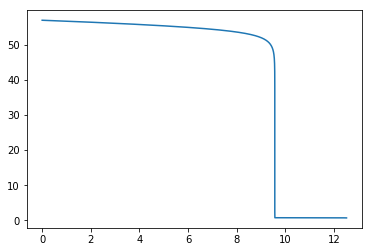

In [21]:
plt.plot(urange,rnpf[:,-100])
#plt.plot(vrange,rnpf[0,:])
plt.show()